In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from PIL import Image
import glob
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


In [2]:
df = pd.read_csv("BreaKHis_v1/histology_slides/breast/image_data.csv")

# Extract image-related information from the path column if it exists
if 'path_to_image' in df.columns:
    df['image_name'] = df['path_to_image'].apply(lambda x: os.path.basename(x))
    #df = df.drop(columns=['path_to_image'])

print(df.head())


                                       path_to_image Benign or Malignant  \
0  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
1  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
2  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
3  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
4  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   

  Cancer Type Magnification                      image_name  
0    Adenosis          100X  SOB_B_A-14-22549AB-100-011.png  
1    Adenosis          100X  SOB_B_A-14-22549AB-100-005.png  
2    Adenosis          100X  SOB_B_A-14-22549AB-100-004.png  
3    Adenosis          100X  SOB_B_A-14-22549AB-100-010.png  
4    Adenosis          100X  SOB_B_A-14-22549AB-100-006.png  


#### Exploration Data Analysis

##### Vectorize images

In [3]:
image_data = []

for index, row in df.iterrows():
    img = load_img(row['path_to_image'], target_size=(224, 224, 3))
    img_array = img_to_array(img)  
    image_data.append(img_array)

df['image_data'] = image_data

In [4]:
df['image_data'].head()

0    [[[192.0, 180.0, 202.0], [174.0, 164.0, 198.0]...
1    [[[179.0, 172.0, 179.0], [187.0, 152.0, 174.0]...
2    [[[201.0, 211.0, 203.0], [198.0, 198.0, 200.0]...
3    [[[206.0, 213.0, 206.0], [208.0, 213.0, 207.0]...
4    [[[150.0, 145.0, 167.0], [156.0, 143.0, 173.0]...
Name: image_data, dtype: object

##### Check for duplicated images

##### Check dataset distribution

In [ ]:
# Display dataset summary
print(f"Dataset contains {len(df)} images.")

# Calculate raw counts and percentages
tumor_summary = df["Benign or Malignant"].value_counts().reset_index()
tumor_summary.columns = ["Benign or Malignant", "Count"]
tumor_summary["Percentage (%)"] = round((tumor_summary["Count"] / len(df)) * 100, 2)

# Summary of tumor classes and types
print("\nSummary of tumor classes:")
print(tumor_summary)

print("\nSummary of tumor types:")
print(df[["Benign or Malignant","Cancer Type"]].value_counts())

In [ ]:
benign_data = df[df['Benign or Malignant'] == 'Benign']
malignant_data = df[df['Benign or Malignant'] == 'Malignant']

# Group for Benign tumors
benign_grouped = benign_data.groupby('Magnification').size().reset_index(name='Count')

# Group for Malignant tumors
malignant_grouped = malignant_data.groupby('Magnification').size().reset_index(name='Count')

# Plot for Benign tumors
plt.figure(figsize=(8, 5))
sns.barplot(data=benign_grouped, x='Magnification', y='Count', palette='viridis')
plt.title('Benign Tumors by Magnification', fontsize=12)
plt.xlabel('', fontsize=10)  # No label for x-axis
plt.ylabel('', fontsize=10)  # No label for y-axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Plot for Malignant tumors
plt.figure(figsize=(8, 5))
sns.barplot(data=malignant_grouped, x='Magnification', y='Count', palette='viridis')
plt.title('Malignant Tumors by Magnification', fontsize=12)
plt.xlabel('', fontsize=10)  # No label for x-axis
plt.ylabel('', fontsize=10)  # No label for y-axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


### Binary classification

#### Target variable and Train, test split

In [ ]:
X = np.array(df['image_data'].tolist())  # Convert Series to a numpy array
# Flatten X (from 3D to 2D)
X = X.reshape(X.shape[0], -1)  # Flatten each image into a 1D vector

In [ ]:
df['target'] = df['Benign or Malignant'].apply(lambda x: 0 if x == "Benign" else 1)
y = df['target'].values  # Assuming the target is in a column 'target'

# Split the dataset into training and testing subsets
#X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state = 1, shuffle = True)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.50, random_state = 1, stratify=y_train, shuffle=True)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp, shuffle=True)

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

### Models

#### Model 1
##### 2 hidden layers with 16 hidden units each

In [ ]:
# Build the Sequential model
model = Sequential()

# First hidden layer with input_dim specified
model.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))

# Second hidden layer
model.add(Dense(16, activation='relu'))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_val, y_val))


In [ ]:
model.summary()

In [ ]:
# Extracting data from the history object
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Generate the range for epochs
epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the test data
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

In [ ]:
# Generate predictions
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary labels

# Display some predicted probabilities and corresponding predictions
print("\nSample Predictions (Probability -> Binary):")
for i in range(10):  # Show the first 5 predictions
    print(f"Probability: {y_pred_prob[i][0]:.4f}, Predicted Class: {y_pred[i][0]}, Actual Class: {y_test[i]}")

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### Model 2
##### 3 hidden layers with 16 hidden units each
##### Tested 3 hidden layers with 32 units each, but the results were unsatisfactory

In [ ]:
# Build the Sequential model
model_2 = Sequential()

# First hidden layer with input_dim specified and more hidden units
#model_2.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model_2.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))

# Second hidden layer with more hidden units
#model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(16, activation='relu'))

# Third hidden layer with more hidden units
#model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(16, activation='relu'))

# Output layer for binary classification
model_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_2.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history_2 = model_2.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_val, y_val))


In [ ]:
model_2.summary()

In [ ]:
# Extracting data from the history object
history_dict = history_2.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Generate the range for epochs
epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the test data
results = model_2.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

In [ ]:
# Generate predictions
y_pred_prob = model_2.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary labels

# Display some predicted probabilities and corresponding predictions
print("\nSample Predictions (Probability -> Binary):")
for i in range(10):  # Show the first 5 predictions
    print(f"Probability: {y_pred_prob[i][0]:.4f}, Predicted Class: {y_pred[i][0]}, Actual Class: {y_test[i]}")

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### Model 3
##### Equivalent to model 2 but with the loss function mse instead
##### Also tried tanh activation function 

In [ ]:
# Build the Sequential model
model_3 = Sequential()

# First hidden layer with input_dim specified and more hidden units
#model_3.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))
model_3.add(Dense(16, activation='tanh', input_dim=X_train.shape[1]))

# Second hidden layer with more hidden units
#model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(16, activation='tanh'))

# Third hidden layer with more hidden units
#model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(16, activation='tanh'))

# Output layer for binary classification
model_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_3.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='mse',
              metrics=['accuracy'])

# Train the model
history_3 = model_3.fit(X_train, y_train, epochs=20, batch_size=30, validation_data=(X_val, y_val))


In [ ]:
model_3.summary()

In [ ]:
# Extracting data from the history object
history_dict = history_3.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Generate the range for epochs
epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the test data
results = model_3.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

In [ ]:
# Generate predictions
y_pred_prob = model_3.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary labels

# Display some predicted probabilities and corresponding predictions
print("\nSample Predictions (Probability -> Binary):")
for i in range(10):  # Show the first 5 predictions
    print(f"Probability: {y_pred_prob[i][0]:.4f}, Predicted Class: {y_pred[i][0]}, Actual Class: {y_test[i]}")

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


#### Model 4
##### CNN implementation

In [20]:
X = np.array(df['image_data'].tolist()) # Convert Series to a numpy array
X = X.reshape(X.shape[0], -1)

# Normalize the image data (pixel values between 0 and 1)
# X = X / 255.0  # Scale pixel values to [0, 1]

df['target'] = df['Benign or Malignant'].apply(lambda x: 0 if x == "Benign" else 1)
y = df['target'].values  # Assuming the target is in a column 'target'

# Split the dataset into training (60%), testing (20%), and validation (20%) subsets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=1, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=1, shuffle=True)

# Verify the shapes of the splits
# print(f"Training data shape: {X_train.shape}, {y_train.shape}")
# print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
# print(f"Test data shape: {X_test.shape}, {y_test.shape}")

In [21]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
'''
X = np.array(df['image_data'].tolist())  # Convert Series to a numpy array
# Flatten X (from 3D to 2D)
#X = X.reshape(X.shape[0], -1)  # Flatten each image into a 1D vector

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp, shuffle=True)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
'''

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Initialize ImageDataGenerator
# datagen = ImageDataGenerator(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )

# # Load minority class images
# benign_images = df[df['target'] == 0]['image_data'].values

# # Generate exactly 500 augmented images
# target_count = 500
# augmented_images = []
# for img in benign_images:
#     img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels)
#     for batch in datagen.flow(img, batch_size=1):
#         augmented_images.append(batch[0])
#         if len(augmented_images) >= target_count:
#             break
#     if len(augmented_images) >= target_count:
#         break

# # Convert augmented images to NumPy array
# augmented_images = np.array(augmented_images)

# # Flatten augmented images to match the shape of X_train
# augmented_images_flattened = augmented_images.reshape(augmented_images.shape[0], -1)

# # Add augmented data to training set
# X_train = np.vstack((X_train, augmented_images_flattened))
# y_train = np.hstack(([0] * len(augmented_images_flattened), y_train))

# # Verify class balance
# print("Updated class distribution:")
# print(pd.Series(y_train).value_counts())


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use data augmentation on the minority class
minority_class = np.where(y_train == 0)[0]
minority_class_images = X_train[minority_class]
minority_class_label = y_train[minority_class]

# Generate augmented images
augmented_images = []
augmented_labels = []
for i in range(700):
    img = minority_class_images[i]
    img = img.reshape((224, 224, 3))  # Reshape to 3D
    img = np.expand_dims(img, axis=0)  # Add batch dimension to make it 4D
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(minority_class_label[i])
        break
        
# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Reshape X_train back to 4D
X_train_reshaped = X_train.reshape(-1, 224, 224, 3)

# Combine augmented images with original images
X_train_augmented = np.vstack((X_train_reshaped, augmented_images))
y_train_augmented = np.hstack((y_train, augmented_labels))

In [15]:
print(pd.Series(y_train_augmented).value_counts())

1    3800
0    2436
dtype: int64


In [23]:
X_val_reshaped = X_val.reshape(-1, 224, 224, 3)
X_test_reshaped = X_test.reshape(-1, 224, 224, 3)
X_train_reshaped = X_train.reshape(-1, 224, 224, 3)

In [ ]:
from tensorflow.keras.layers import Dropout

# Build the CNN model with dropout
model_4 = Sequential()

# First convolutional layer
model_4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.25))  # Add dropout after the first pooling layer

# Second convolutional layer
model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.25))  # Add dropout after the second pooling layer

# Third convolutional layer
model_4.add(Conv2D(128, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.25))  # Add dropout after the third pooling layer

# Flatten the feature maps
model_4.add(Flatten())

# Fully connected layers
model_4.add(Dense(64, activation='relu'))  # First dense layer
model_4.add(Dropout(0.5))  # Add dropout after the first dense layer
model_4.add(Dense(16, activation='relu'))  # Second dense layer
model_4.add(Dropout(0.5))  # Add dropout after the second dense layer

# Output layer for binary classification
model_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_4.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',  # Binary crossentropy is better for binary classification
                metrics=['accuracy'])

# Add EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history_4 = model_4.fit(X_train_reshaped, y_train, epochs=20, batch_size=30, validation_data=(X_val_reshaped, y_val))

Epoch 1/20
185/185 [==============================] - 91s 487ms/step - loss: 0.5715 - accuracy: 0.7901 - val_loss: 0.3687 - val_accuracy: 0.8432
Epoch 2/20
185/185 [==============================] - 90s 485ms/step - loss: 0.3770 - accuracy: 0.8427 - val_loss: 0.3594 - val_accuracy: 0.8516
Epoch 3/20
185/185 [==============================] - 90s 485ms/step - loss: 0.3298 - accuracy: 0.8591 - val_loss: 0.2702 - val_accuracy: 0.8794
Epoch 4/20
185/185 [==============================] - 90s 485ms/step - loss: 0.2841 - accuracy: 0.8817 - val_loss: 0.2636 - val_accuracy: 0.8912
Epoch 5/20
185/185 [==============================] - 90s 486ms/step - loss: 0.2473 - accuracy: 0.9005 - val_loss: 0.2311 - val_accuracy: 0.8988
Epoch 6/20
185/185 [==============================] - 91s 492ms/step - loss: 0.2222 - accuracy: 0.9082 - val_loss: 0.2567 - val_accuracy: 0.8963
Epoch 7/20
185/185 [==============================] - 90s 484ms/step - loss: 0.1803 - accuracy: 0.9305 - val_loss: 0.2422 - val_ac

In [25]:
predictions = model_4.predict(X_test_reshaped)

# Convert probabilities to binary labels
y_pred = (predictions > 0.5).astype("int32")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

38/38 [==============================] - 5s 119ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       372
           1       0.90      0.96      0.93       815

    accuracy                           0.90      1187
   macro avg       0.89      0.86      0.87      1187
weighted avg       0.90      0.90      0.89      1187



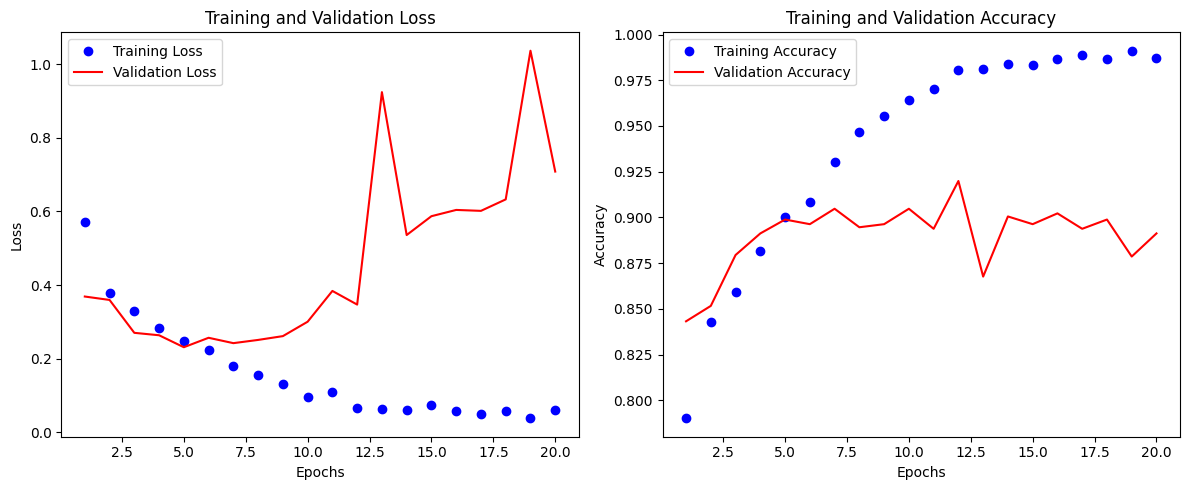

In [26]:
# Extracting data from the history object
history_dict = history_4.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Generate the range for epochs
epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

<h1> Pre-trained models </h1>

In [ ]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers (optional)
base_model.trainable = False

# Add custom layers for binary or multi-class classification
model_ResNet50 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
    # Use Dense(8, activation='softmax') for multi-class classification
])

# Compile the model
model_ResNet50.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy','precision','recall']) #binary
#model_ResNet50.compile(optimizer=Adam(learning_rate=0.001), loss='crossentropy', metrics=['accuracy','precision','recall']) #multiclass

In [ ]:
model_ResNet50.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

In [ ]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
# Load VGG16 without the top layer (pre-trained on ImageNet)
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base layers (optional)
base_model_vgg16.trainable = False

# Add custom layers for binary or multi-class classification
model_vgg16 = Sequential([
    base_model_vgg16,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
    # Use Dense(8, activation='softmax') for multi-class classification (e.g., 8 cancer types)
])

# Compile the model
model_vgg16.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy','precision','recall'])

In [ ]:
model_vgg16.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

In [ ]:
# Predict and evaluate
y_pred_vgg16 = model_vgg16.predict(X_test)
y_pred_vgg16 = np.round(y_pred_vgg16)
print(classification_report(y_test, y_pred_vgg16))
print(confusion_matrix(y_test, y_pred_vgg16))